<a href="https://colab.research.google.com/github/syed001sufiyan/Challenging-Fake-Image-Detection-Using-GAN/blob/main/README/GANExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# you can change to fashion_mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# (28, 28, 1)
x_train = x_train.astype("float32").reshape(-1, 28, 28, 1) / 255.0

BATCH_SIZE = 128
x_train_ds = (
    tf.data.Dataset.from_tensor_slices(x_train)
      .batch(BATCH_SIZE, drop_remainder=True)
      .prefetch(tf.data.AUTOTUNE)
)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Creates and manages the architectures for the generator and discriminator
class GANArchitecture():
    def __init__(self, input_shape, num_factors):
      self.input_shape = input_shape
      self.num_factors = num_factors

    def create_generator(self):
      model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(100, input_dim = self.num_factors),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(np.prod(self.input_shape), activation="sigmoid"),
        tf.keras.layers.Reshape(self.input_shape)
      ])

      self.generator = model

    def create_discriminator(self):
      model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=self.input_shape),
        tf.keras.layers.Dense(100),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(1, activation="sigmoid")
      ])

      self.discriminator = model

    def __call__(self):
      self.create_generator()
      self.create_discriminator()
      return self

In [ ]:
class GANTrainerModel(tf.keras.models.Model):
  def __init__(self, input_shape, num_factors, batch_size):
    super(GANTrainerModel, self).__init__()
    self.arch = GANArchitecture(input_shape, num_factors)()

    self.batch_size = batch_size
    self.num_factors = num_factors

    self.true_labels = tf.ones((batch_size, 1))
    self.false_labels = tf.zeros((batch_size, 1))

    self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    self.gen_loss_tracker = tf.keras.metrics.Mean(name="loss_after_gen")

  @property
  def metrics(self):
    return [self.loss_tracker, self.gen_loss_tracker]

  def compile(self, d_optimizer, g_optimizer, loss):
    super(GANTrainerModel, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss = loss

  def train_step(self, data):
    # [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
    # tf.random.normal NOT tf.random.uniform
    rand_factors = tf.random.normal((self.batch_size, self.num_factors))
    gen_imgs = self.arch.generator(rand_factors)

    disc_data = tf.concat([data, gen_imgs], axis=0)
    disc_labels = tf.concat([self.true_labels, self.false_labels], axis=0)

    # discriminator
    with tf.GradientTape() as tape:
      disc_pred = self.arch.discriminator(disc_data)
      disc_loss = self.loss(disc_labels, disc_pred)

    disc_vars = self.arch.discriminator.trainable_variables
    disc_gradients = tape.gradient(disc_loss, disc_vars)
    self.d_optimizer.apply_gradients(zip(disc_gradients, disc_vars))

    # generator
    rand_factors = tf.random.normal((self.batch_size, self.num_factors))
    trick_labels = self.true_labels

    with tf.GradientTape() as tape:
      gen_imgs = self.arch.generator(rand_factors)
      gen_pred = self.arch.discriminator(gen_imgs)
      gen_loss = self.loss(trick_labels, gen_pred)

    gen_vars = self.arch.generator.trainable_variables
    gen_gradients = tape.gradient(gen_loss, gen_vars)
    self.d_optimizer.apply_gradients(zip(gen_gradients, gen_vars))

    self.loss_tracker.update_state(disc_loss)
    self.gen_loss_tracker.update_state(gen_loss)
    return {
        "loss" : self.loss_tracker.result(),
        "gen_loss": self.gen_loss_tracker.result()
    }


In [ ]:
INPUT_SHAPE = (28, 28, 1)
NUM_FACTORS = 100

trainer = GANTrainerModel(INPUT_SHAPE, NUM_FACTORS, BATCH_SIZE)
trainer.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    d_optimizer = tf.keras.optimizers.Adam(),
    g_optimizer = tf.keras.optimizers.Adam()
)

In [ ]:
trainer.fit(x_train_ds, epochs=20)

Epoch 1/20
468/468 [==============================] - 7s 7ms/step - loss: 0.0822 - gen_loss: 5.3608
Epoch 2/20
468/468 [==============================] - 2s 3ms/step - loss: 0.0387 - gen_loss: 8.9848
Epoch 3/20
468/468 [==============================] - 2s 3ms/step - loss: 0.0647 - gen_loss: 5.7729
Epoch 4/20
468/468 [==============================] - 2s 4ms/step - loss: 0.1078 - gen_loss: 5.1826
Epoch 5/20
468/468 [==============================] - 2s 3ms/step - loss: 0.0983 - gen_loss: 4.3584
Epoch 6/20
468/468 [==============================] - 2s 4ms/step - loss: 0.1500 - gen_loss: 4.2120
Epoch 7/20
468/468 [==============================] - 2s 4ms/step - loss: 0.1628 - gen_loss: 4.1068
Epoch 8/20
468/468 [==============================] - 2s 3ms/step - loss: 0.1711 - gen_loss: 3.8469
Epoch 9/20
468/468 [==============================] - 2s 3ms/step - loss: 0.1907 - gen_loss: 4.0090
Epoch 10/20
468/468 [==============================] - 2s 4ms/step - loss: 0.2020 - gen_loss: 3.9836

In [ ]:
rand_factors = tf.random.normal((1, NUM_FACTORS))
gen_imgs = trainer.arch.generator(rand_factors)

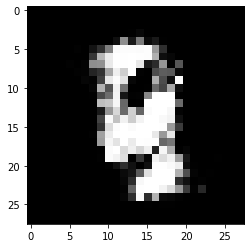

In [ ]:
plt.imshow(tf.reshape(gen_imgs, [28, 28]), cmap="gray")